# DS Automation Assignment

Using our prepared churn data from week 2:
- use pycaret to find an ML algorithm that performs best on the data
    - Choose a metric you think is best to use for finding the best model; by default, it is accuracy but it could be AUC, precision, recall, etc. The week 3 FTE has some information on these different metrics.
- save the model to disk
- create a Python script/file/module with a function that takes a pandas dataframe as an input and returns the probability of churn for each row in the dataframe
    - your Python file/function should print out the predictions for new data (new_churn_data.csv)
    - the true values for the new data are [1, 0, 0, 1, 0] if you're interested
- test your Python module and function with the new data, new_churn_data.csv
- write a short summary of the process and results at the end of this notebook
- upload this Jupyter Notebook and Python file to a Github repository, and turn in a link to the repository in the week 5 assignment dropbox

*Optional* challenges:
- return the probability of churn for each new prediction, and the percentile where that prediction is in the distribution of probability predictions from the training dataset (e.g. a high probability of churn like 0.78 might be at the 90th percentile)
- use other autoML packages, such as TPOT, H2O, MLBox, etc, and compare performance and features with pycaret
- create a class in your Python module to hold the functions that you created
- accept user input to specify a file using a tool such as Python's `input()` function, the `click` package for command-line arguments, or a GUI
- Use the unmodified churn data (new_unmodified_churn_data.csv) in your Python script. This will require adding the same preprocessing steps from week 2 since this data is like the original unmodified dataset from week 1.

### Load Data

In [1]:
import pandas as pd
import seaborn as sns

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

df = pd.read_csv('churn_data.csv', index_col = 'customerID')
df

The scikit-learn version is 0.23.2.


,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...
6840-RESVB,24,Yes,One year,Mailed check,84.80,1990.50,No
2234-XADUH,72,Yes,One year,Credit card (automatic),103.20,7362.90,No
4801-JZAZL,11,No,Month-to-month,Electronic check,29.60,346.45,No


#### Filtering Data

In [2]:
df['Churn'] == 'Yes'

customerID
7590-VHVEG    False
5575-GNVDE    False
3668-QPYBK     True
7795-CFOCW    False
9237-HQITU     True
              ...  
6840-RESVB    False
2234-XADUH    False
4801-JZAZL    False
8361-LTMKD     True
3186-AJIEK    False
Name: Churn, Length: 7043, dtype: bool

In [3]:
churn_df = df[df['Churn'] == 'Yes']
churn_df.head()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
9305-CDSKC,8,Yes,Month-to-month,Electronic check,99.65,820.50,Yes
7892-POOKP,28,Yes,Month-to-month,Electronic check,104.80,3046.05,Yes
0280-XJGEX,49,Yes,Month-to-month,Bank transfer (automatic),103.70,5036.30,Yes


#### Missing Values

In [4]:
# returns the number of missing values in each column
df.isna().sum()

tenure             0
PhoneService       0
Contract           0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

<AxesSubplot:>

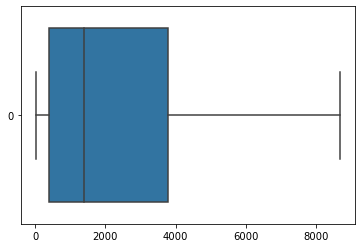

In [5]:
# fill in any missing total charges with the median total charge value
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
sns.boxplot(data=df['TotalCharges'], orient='h')

In [6]:
# returns the number of missing values in each column
df.isna().sum()

tenure            0
PhoneService      0
Contract          0
PaymentMethod     0
MonthlyCharges    0
TotalCharges      0
Churn             0
dtype: int64

#### Converting Categorical Values to Numeric

In [7]:
#replacing values: no churn = 0, yes churn = 1
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})

#replacing values: no phone service = 0, yes phone service = 1
df['PhoneService'] = df['PhoneService'].replace({'No': 0, 'Yes': 1})

#replacing values: month-to-month contract = 0, one year contract = 1
df['Contract'] = df['Contract'].replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

#replacing values: payment methods: electronic check = 0, mailed check = 1, 
# bank transfer (automatic) = 2, credit card (automatic) = 3
df['PaymentMethod'] = df['PaymentMethod'].replace({'Electronic check': 0, 'Mailed check': 1, 
                                                   'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3})

In [8]:
# check that all columns are numbers now
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   PhoneService    7043 non-null   int64  
 2   Contract        7043 non-null   int64  
 3   PaymentMethod   7043 non-null   int64  
 4   MonthlyCharges  7043 non-null   float64
 5   TotalCharges    7043 non-null   float64
 6   Churn           7043 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 698.2+ KB


In [9]:
# This is giving us the data where churn is a yes
Churn_info = df[df['Churn'] == 1]
Churn_info

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
3668-QPYBK,2,1,0,1,53.85,108.15,1
9237-HQITU,2,1,0,0,70.70,151.65,1
9305-CDSKC,8,1,0,0,99.65,820.50,1
7892-POOKP,28,1,0,0,104.80,3046.05,1
0280-XJGEX,49,1,0,2,103.70,5036.30,1
...,...,...,...,...,...,...,...
1699-HPSBG,12,1,1,0,59.80,727.80,1
8775-CEBBJ,9,1,0,2,44.20,403.35,1
6894-LFHLY,1,1,0,0,75.75,75.75,1


# AutoML with pycaret

We will need to install the Python package with conda or pip: conda install -c conda-forge pycaret -y. Then we can import the functions we need:

In [10]:
!conda install -c conda-forge pycaret -y

Solving environment: ...working... done

# All requested packages already installed.



In [11]:
from pycaret.classification import setup, compare_models, predict_model, save_model, load_model

Next, we can setup our autoML:

In [12]:
automl = setup(df, target='Churn')

,Description,Value
0,session_id,1071
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(7043, 7)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
?setup

In [14]:
automl[6]

{'lr': <pycaret.containers.models.classification.LogisticRegressionClassifierContainer at 0x228282aeb20>,
 'knn': <pycaret.containers.models.classification.KNeighborsClassifierContainer at 0x228282aee80>,
 'nb': <pycaret.containers.models.classification.GaussianNBClassifierContainer at 0x228282ae880>,
 'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x228282aeac0>,
 'svm': <pycaret.containers.models.classification.SGDClassifierContainer at 0x22828305130>,
 'rbfsvm': <pycaret.containers.models.classification.SVCClassifierContainer at 0x228283053a0>,
 'gpc': <pycaret.containers.models.classification.GaussianProcessClassifierContainer at 0x228283054c0>,
 'mlp': <pycaret.containers.models.classification.MLPClassifierContainer at 0x22828305580>,
 'ridge': <pycaret.containers.models.classification.RidgeClassifierContainer at 0x228282f9a60>,
 'rf': <pycaret.containers.models.classification.RandomForestClassifierContainer at 0x228282f9be0>,
 'qda': <pycaret.c

Next we will run the autoML to find the best model

In [15]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7872,0.8320,0.4905,0.6332,0.5516,0.4154,0.4219,0.0960
lr,Logistic Regression,0.7866,0.8282,0.4996,0.6283,0.5557,0.4180,0.4232,0.4150
ada,Ada Boost Classifier,0.7864,0.8283,0.4860,0.6336,0.5487,0.4122,0.4192,0.0520
ridge,Ridge Classifier,0.7862,0.0000,0.4519,0.6444,0.5298,0.3974,0.4086,0.0050
lda,Linear Discriminant Analysis,0.7856,0.8214,0.5148,0.6213,0.5621,0.4220,0.4258,0.0050
lightgbm,Light Gradient Boosting Machine,0.7730,0.8170,0.4951,0.5915,0.5374,0.3891,0.3927,0.0830
xgboost,Extreme Gradient Boosting,0.7698,0.8054,0.4852,0.5853,0.5292,0.3790,0.3827,0.1430
rf,Random Forest Classifier,0.7643,0.7885,0.4800,0.5722,0.5213,0.3667,0.3697,0.1340
knn,K Neighbors Classifier,0.7584,0.7309,0.4368,0.5630,0.4911,0.3364,0.3414,0.0150
et,Extra Trees Classifier,0.7535,0.7657,0.4815,0.5463,0.5109,0.3473,0.3491,0.1000


Our best_model object now holds the highest-scoring model. We can also set an argument sort in compare_models to choose another metric as our scoring metric. By default, it uses accuracy (and we can see the table above is sorted by accuracy). We could set this to sort='Precision' to use precision (TP / (TP + FN)), for example.

In [16]:
best_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1071, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

As of now, our best model is GradientBoostingClassifier which may change on different runs. We will use this best model to make predictions.

In [17]:
df.iloc[-2:-1].shape

(1, 7)

We are selecting the last row, but using the indexing [-2:-1] to make it a 2D array instead of 1D (which throws an error). Try running df.iloc[-1].shape and df.iloc[-2:-1].shape to see how they differ.

However, this only works if we set preprocess=False in our setup function. Otherwise the order of features may be different

A more robust way (in case we are using preprocessing with autoML) is to use pycaret's predict_model function:

In [18]:
#df.iloc[-3:-1].shape

In [19]:
predict_model(best_model, df.iloc[-2:-1])

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Label,Score
customerID,,,,,,,,,
8361-LTMKD,4,1,0,1,74.4,306.6,1,1,0.5517


## Saving and loading our model

Now, we want to save our trained model so we can use it in a Python file later. pycaret has a handy function for this, which saves the model as a pickle file:

In [20]:
save_model(best_model, 'GBC')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Churn',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=3, max_features=None,
                                             max_leaf_nodes=None,
                                             min_i

pickle is a built-in module in the Python standard library which allows for saving and loading of binary data. It's data that's been encoded (usually using hexidecimal encoding) to a file, and we can store any Python object as-is in a pickle file. Then we can load the data from the file and be right back where we left off. To do this with pickle, we would do:

In [21]:
import pickle

with open('GBC_model.pk', 'wb') as f:
    pickle.dump(best_model, f)

Here, we use the built-in open function to open a file with the name LDA_model.pk, then open it for writing with 'w' and in a binary format using 'b'. We save that file object in the variable f. The with statement automatically closes the file after we exit the with statement, otherwise, we should call the function close from the file object f. Then we use pickle to save our data to the file. We could reload it like this:

In [22]:
with open('GBC_model.pk', 'rb') as f:
    loaded_model = pickle.load(f)

In [23]:
new_data = df.iloc[-2:-1].copy()
new_data.drop('Churn', axis=1, inplace=True)
loaded_model.predict(new_data)

ValueError: Number of features of the model must match the input. Model n_features is 11 and input n_features is 6 

In [24]:
loaded_lda = load_model('GBC')

Transformation Pipeline and Model Successfully Loaded


In [25]:
predict_model(loaded_lda, new_data)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Label,Score
customerID,,,,,,,,
8361-LTMKD,4,1,0,1,74.4,306.6,1,0.5517


## Making a python module to make predictions

In [26]:
from IPython.display import Code

Code('predict_churn.py')

import pandas as pd
from pycaret.classification import predict_model, load_model


def load_data(filepath):
    """loads churn data into a dataframe from a string filepath"""
    df = pd.read_csv(filepath, index_col='customerID')
    return df 


def make_predictions(df):
    'load our model'
    model = load_model('GBC')
    """Uses the pycaret best model to make predictions on data in the df dataframe"""
    predictions = predict_model(model, data=df)
    predictions.rename({'Label': 'Churn_prediction'}, axis=1, inplace=True)
    predictions['Churn_prediction'].replace({1: 'Churn', 0: 'No churn'}, inplace=True)
    
    return predictions['Churn_prediction']

if __name__ == "__main__":
    df = load_data('new_churn_data.csv')
    predictions = make_predictions(df)
    print('predictions:')
    print(predictions)

In [27]:
%run predict_churn.py

Transformation Pipeline and Model Successfully Loaded
predictions:
customerID
9305-CKSKC       Churn
1452-KNGVK    No churn
6723-OKKJM    No churn
7832-POPKP    No churn
6348-TACGU    No churn
Name: Churn_prediction, dtype: object


The true values for the new data are [1, 0, 0, 1, 0]. In our prediction we got [1, 0, 0, 0, 0]. We got 1 false negative and 4 accurate predictions so our model appears to be working pretty well!

# Summary

For this run, the best model for predicting churn was the gradient boosting classifier model. Using this best model, we got a score of 0.5517. When using our model on the new_churn_data dataset, our model was pretty close to accurately predicting churn. With the true values for this dataset being [1, 0, 0, 1, 0] and our predicted results being [1, 0, 0, 0, 0]. We can see that we got 1 false negative and 4 accurate predictions. 